In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import random
import os
import numpy as np


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything()

In [3]:
res = []
for file_path in glob.glob('../data/*.csv'):
    res.append(pd.read_csv(file_path))
df = pd.concat(res).sort_values('datetime').reset_index(drop=True)

In [4]:
df.head(3)

,wrestler,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,final_opponent,datetime
0,蒼樹山,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,200001
1,金開山,1,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,和歌乃山,200001
2,魁皇,0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,武双山,200001


In [5]:
df = df.dropna().reset_index(drop=True)

In [6]:
len(df)

4340

In [7]:
df.rename(columns={'day_15': 'final_day'}, inplace=True)
df['wins_at_day_14'] = df.iloc[:, df.columns.str.startswith('day_')].sum(axis=1)
# df.rename(columns={'final_day': 'day_15'}, inplace=True)

In [8]:
df.head(3)

,wrestler,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,final_day,final_opponent,datetime,wins_at_day_14
0,金開山,1,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,和歌乃山,200001,6.0
1,魁皇,0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,武双山,200001,7.0
2,曙,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,貴乃花,200001,11.0


Text(0, 0.5, '人数')

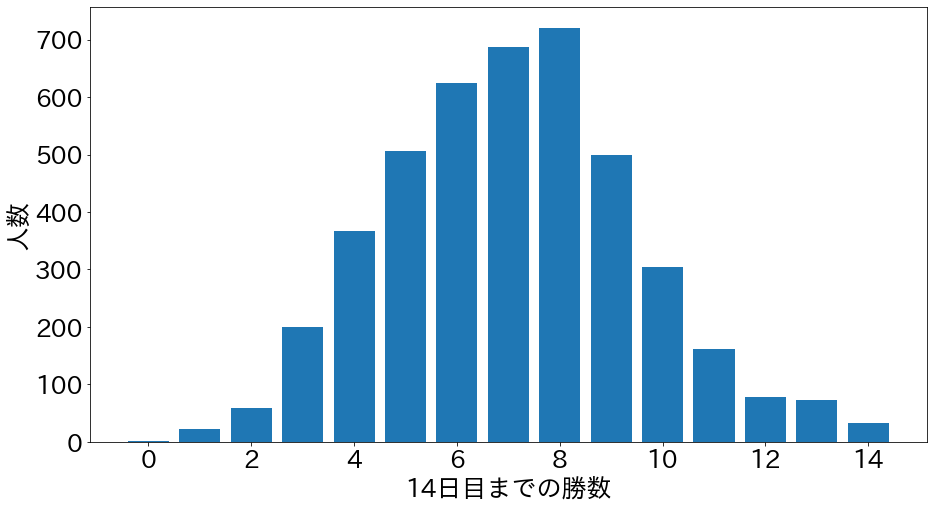

In [9]:
plt.rcParams["font.size"] = 25
plt.figure(figsize=(15, 8))
plt.bar(
    df.groupby('wins_at_day_14')['final_day'].count().index,
    df.groupby('wins_at_day_14')['final_day'].count()    
)
plt.xlabel('14日目までの勝数')
plt.ylabel('人数')

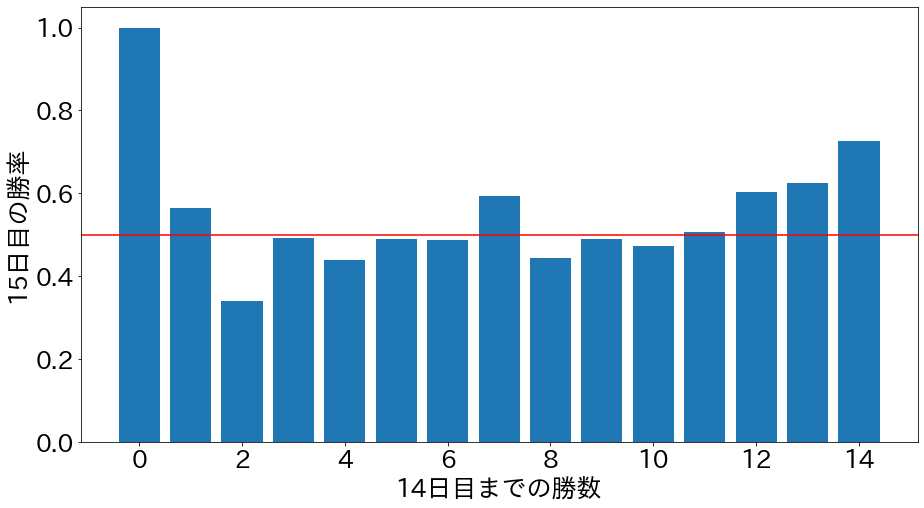

In [10]:
plt.rcParams["font.size"] = 25
plt.figure(figsize=(15, 8))
plt.bar(
    df.groupby('wins_at_day_14')['final_day'].mean().index,
    df.groupby('wins_at_day_14')['final_day'].mean()    
)
plt.xlabel('14日目までの勝数')
plt.ylabel('15日目の勝率')
plt.axhline(y=0.5, color='r', linestyle='-')

# features

In [11]:
df.head(2)

,wrestler,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,final_day,final_opponent,datetime,wins_at_day_14
0,金開山,1,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,和歌乃山,200001,6.0
1,魁皇,0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,武双山,200001,7.0


In [12]:
_tmp = df[['wrestler', 'datetime', 'wins_at_day_14']].rename(columns={'wrestler': 'final_opponent', 'wins_at_day_14': 'final_opponent_wins_at_day_14'})
df = pd.merge(df, _tmp, on=['final_opponent', 'datetime'], how='left')

In [13]:
split_datetime = 201501
train = df[df['datetime']<split_datetime]
test = df[~(df['datetime']<split_datetime)]

In [14]:
len(test['datetime'].unique())

28

# benchmark

In [15]:
TRAIN_COL = list(df.iloc[:, df.columns.str.startswith('day_')].columns) + ['wins_at_day_14']
TARGET = 'final_day'

X_train = train[TRAIN_COL]
X_test = test[TRAIN_COL]

y_train = train[TARGET]
y_test = test[TARGET]

In [16]:
import pandas as pd
import lightgbm as lgb


def lgbm(X_tr, X_val, y_tr, y_val, X_test, params, categorical_features):

    lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train, categorical_feature=categorical_features)

    model = lgb.train(
        params, lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        num_boost_round=10000,
        early_stopping_rounds=30,
        verbose_eval=10
    )

    y_valid = model.predict(X_val)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns.values
    fold_importance_df["importance"] = model.feature_importance(importance_type='gain')

    return y_pred, y_valid, model, fold_importance_df


/Users/shotaroishihara/project/sumo-predictor/env/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [17]:
from sklearn.model_selection import KFold, TimeSeriesSplit
import seaborn as sns


N_SPLITS = 8

lgbm_params = {
    'max_depth': 16,
    'num_leaves': 4,
    'min_data_in_leaf': 10,
    'objective': 'binary',
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "feature_fraction": 0.7,
    "bagging_freq": 1,
    "bagging_fraction": 0.7,
    "metric": 'auc',
    "lambda_l1": 0.3,
    "verbosity": -1,
    "random_state": 42,
  }

categorical_features = list(df.iloc[:, df.columns.str.startswith('day_')].columns)

METRIC = 'auc'

In [105]:
train_basho, valid_basho = np.split(train['datetime'].unique(), [59])
len(valid_basho)

28

In [18]:
y_preds = []
models = []
feature_importances = pd.DataFrame()
# oof_train = np.zeros((len(X_train),))

for split_index in range(30, 60):

    train_basho, valid_basho = np.split(train['datetime'].unique(), [split_index])
    valid_basho = valid_basho[0:28]

    X_tr = X_train[train['datetime'].isin(train_basho)]
    X_val = X_train[train['datetime'].isin(valid_basho)]

    y_tr = y_train[train['datetime'].isin(train_basho)]
    y_val = y_train[train['datetime'].isin(valid_basho)]

    y_pred, y_val, model, fold_importance_df = lgbm(
        X_tr, X_val, y_tr, y_val, X_test, lgbm_params, categorical_features
    )

#     oof_train[valid_index] = y_val
    y_preds.append(y_pred)
    models.append(model)
    feature_importances = pd.concat([feature_importances, fold_importance_df], axis=0)


/Users/shotaroishihara/project/sumo-predictor/env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/shotaroishihara/project/sumo-predictor/env/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.606359	valid_1's auc: 0.521126
[20]	training's auc: 0.622959	valid_1's auc: 0.510817
[30]	training's auc: 0.630191	valid_1's auc: 0.509168
[40]	training's auc: 0.640947	valid_1's auc: 0.513395
Early stopping, best iteration is:
[15]	training's auc: 0.619053	valid_1's auc: 0.521807
Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.608819	valid_1's auc: 0.524812
[20]	training's auc: 0.621951	valid_1's auc: 0.53013
[30]	training's auc: 0.630845	valid_1's auc: 0.525767
[40]	training's auc: 0.639347	valid_1's auc: 0.526096
Early stopping, best iteration is:
[17]	training's auc: 0.621401	valid_1's auc: 0.533913
Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.609539	valid_1's auc: 0.528928
[20]	training's auc: 0.623902	valid_1's auc: 0.533537
[30]	training's auc: 0.634808	valid_1's auc: 0.5258
[40]	training's auc: 0.643556	valid_1's auc: 

Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.576319	valid_1's auc: 0.53973
[20]	training's auc: 0.593276	valid_1's auc: 0.530825
[30]	training's auc: 0.59945	valid_1's auc: 0.522834
[40]	training's auc: 0.611392	valid_1's auc: 0.520981
Early stopping, best iteration is:
[10]	training's auc: 0.576319	valid_1's auc: 0.53973
Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.583634	valid_1's auc: 0.527695
[20]	training's auc: 0.59531	valid_1's auc: 0.526171
[30]	training's auc: 0.602788	valid_1's auc: 0.525811
Early stopping, best iteration is:
[2]	training's auc: 0.548926	valid_1's auc: 0.536004
Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.57844	valid_1's auc: 0.534821
[20]	training's auc: 0.592758	valid_1's auc: 0.526214
[30]	training's auc: 0.603223	valid_1's auc: 0.525218
[40]	training's auc: 0.614842	valid_1's auc: 0.51662
Early stopping, best iteration is:
[11]	training'

In [19]:
scores = [
    m.best_score['valid_1'][METRIC] for m in models
]
score = sum(scores) / len(scores)
print('===CV scores===')
print(score)
print(scores)

===CV scores===
0.5289569964608363
[0.5218067119338238, 0.5339128322107792, 0.5370894184989033, 0.5356774060305659, 0.5471353400550935, 0.5302902902902903, 0.510883907222226, 0.521519451105782, 0.5236784437094996, 0.5244713804713804, 0.5283313204508857, 0.5079767264107425, 0.5065049226441631, 0.5055632289748312, 0.5172522887048379, 0.541584671843421, 0.5342213713102569, 0.538078996881877, 0.5102994952104615, 0.5303131544828962, 0.5269557891091219, 0.5255429688279053, 0.5405329183767589, 0.5405794205794205, 0.5397296555234116, 0.5360040193034104, 0.5371125255403807, 0.5370791367877116, 0.5327833268327427, 0.5457987745015065]


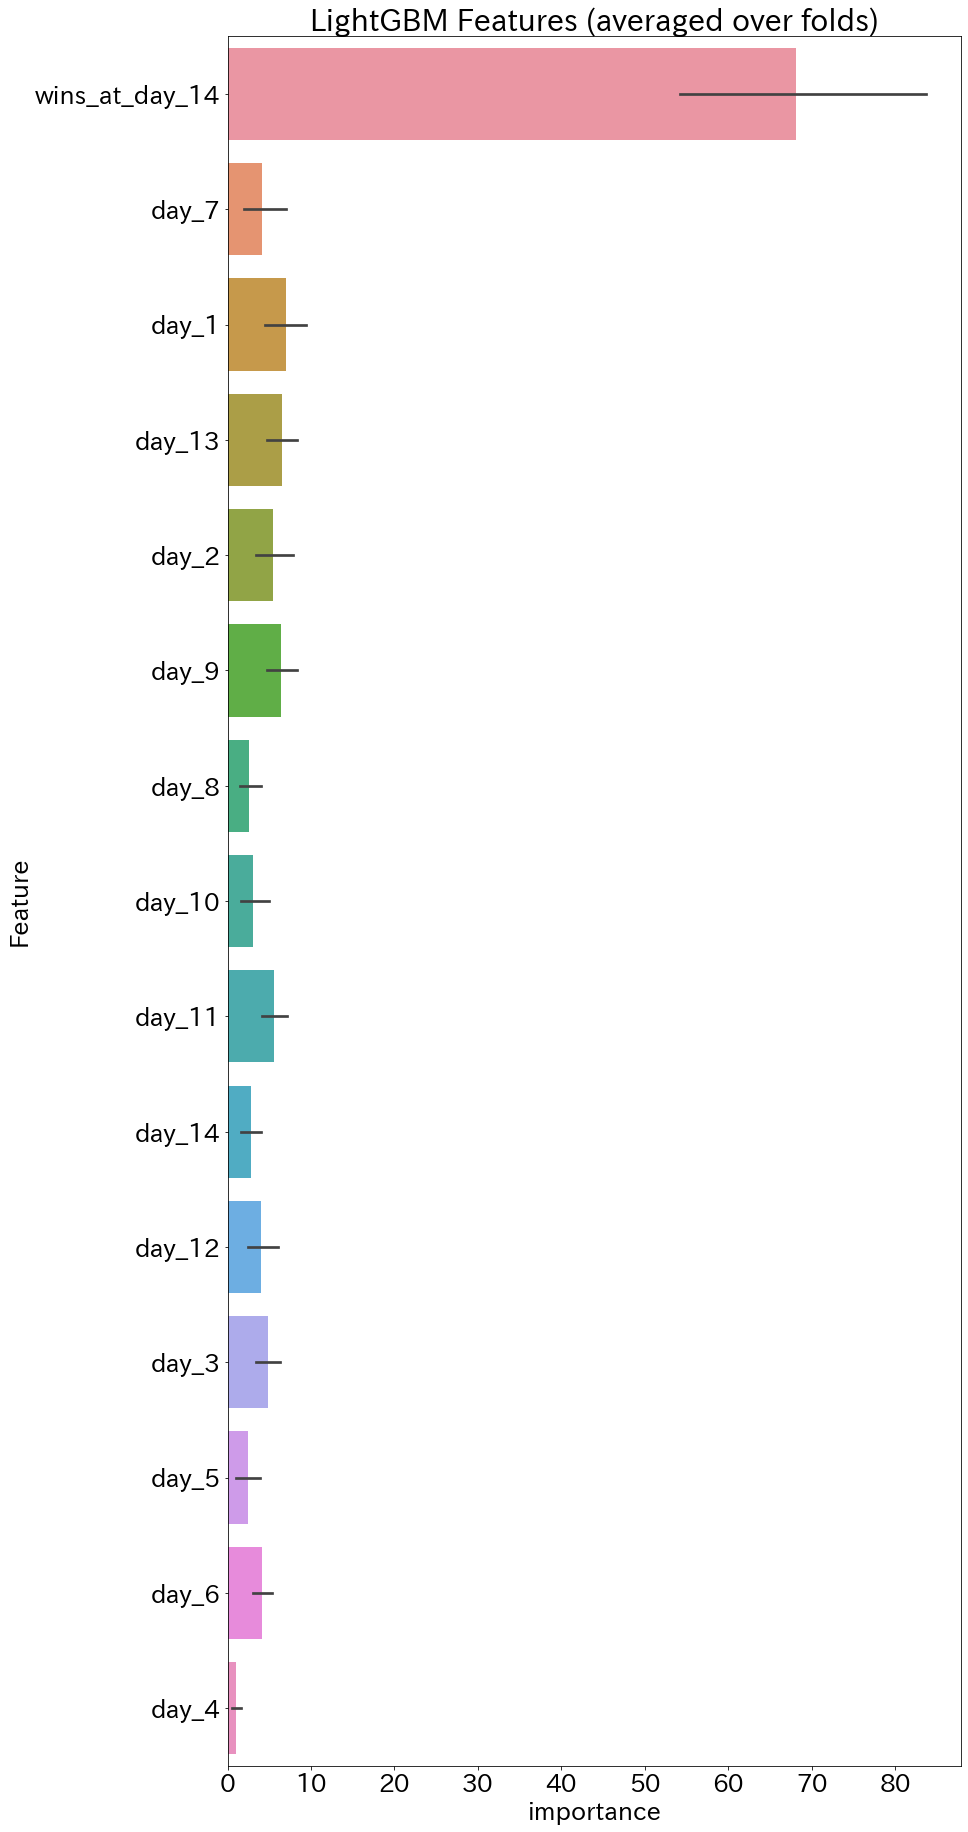

In [20]:
cols = feature_importances.groupby('Feature').mean().sort_values(by="importance", ascending=False)[:200].index

best_features = feature_importances.loc[feature_importances.Feature.isin(cols)]
plt.figure(figsize=(14, 26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()

In [21]:
y_sub = sum(y_preds) / len(y_preds)
y_sub[:10]

array([0.50282107, 0.47271524, 0.50761005, 0.48202334, 0.47408323,
       0.48218501, 0.51979398, 0.50415103, 0.53235139, 0.47033328])

(array([ 44., 176., 241., 152., 145., 149.,  98.,  25.,  12.,   8.]),
 array([0.44804779, 0.46055597, 0.47306415, 0.48557234, 0.49808052,
        0.5105887 , 0.52309688, 0.53560506, 0.54811324, 0.56062142,
        0.57312961]),
 <a list of 10 Patch objects>)

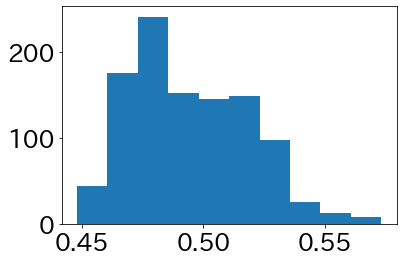

In [22]:
plt.hist(y_sub)

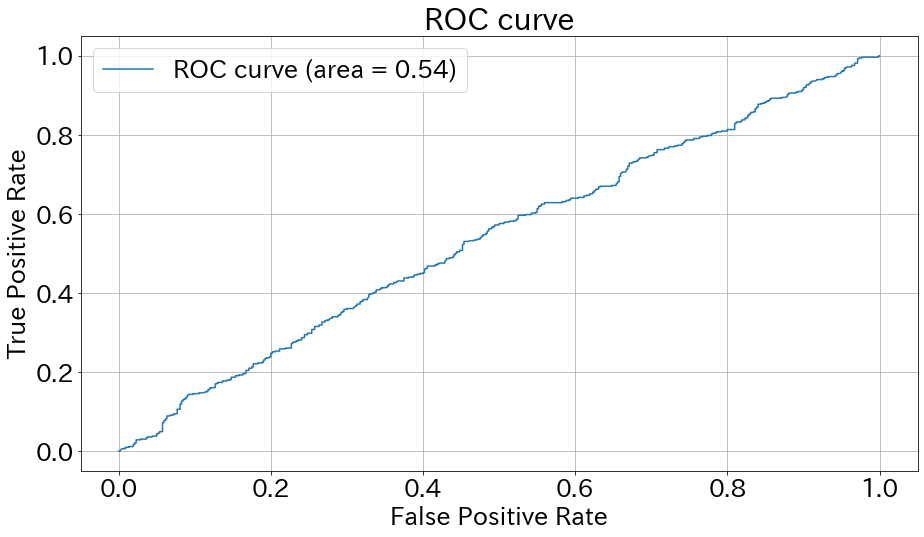

In [23]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_sub)
auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(15, 8))
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [24]:
y_sub = np.where(y_sub > 0.5, 1, 0)
y_sub[:10]

array([1, 0, 1, 0, 0, 0, 1, 1, 1, 0])

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_sub)

array([[333, 187],
       [306, 224]])

In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_sub)

0.5304761904761904

# add feature

In [27]:
TRAIN_COL = list(df.iloc[:, df.columns.str.startswith('day_')].columns) + ['wins_at_day_14', 'final_opponent_wins_at_day_14']
TARGET = 'final_day'

X_train = train[TRAIN_COL]
X_test = test[TRAIN_COL]

y_train = train[TARGET]
y_test = test[TARGET]

In [28]:
y_preds = []
models = []
feature_importances = pd.DataFrame()
# oof_train = np.zeros((len(X_train),))

for split_index in range(30, 60):

    train_basho, valid_basho = np.split(train['datetime'].unique(), [split_index])
    valid_basho = valid_basho[0:28]

    X_tr = X_train[train['datetime'].isin(train_basho)]
    X_val = X_train[train['datetime'].isin(valid_basho)]

    y_tr = y_train[train['datetime'].isin(train_basho)]
    y_val = y_train[train['datetime'].isin(valid_basho)]

    y_pred, y_val, model, fold_importance_df = lgbm(
        X_tr, X_val, y_tr, y_val, X_test, lgbm_params, categorical_features
    )

#     oof_train[valid_index] = y_val
    y_preds.append(y_pred)
    models.append(model)
    feature_importances = pd.concat([feature_importances, fold_importance_df], axis=0)


Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.643357	valid_1's auc: 0.547712
[20]	training's auc: 0.67423	valid_1's auc: 0.554927
[30]	training's auc: 0.680053	valid_1's auc: 0.55569
[40]	training's auc: 0.685827	valid_1's auc: 0.556874
[50]	training's auc: 0.691696	valid_1's auc: 0.555939
[60]	training's auc: 0.698954	valid_1's auc: 0.559679
[70]	training's auc: 0.703292	valid_1's auc: 0.555747
[80]	training's auc: 0.70796	valid_1's auc: 0.554565
[90]	training's auc: 0.715849	valid_1's auc: 0.549108
Early stopping, best iteration is:
[60]	training's auc: 0.698954	valid_1's auc: 0.559679
Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.646923	valid_1's auc: 0.546967
[20]	training's auc: 0.66824	valid_1's auc: 0.558452
[30]	training's auc: 0.671698	valid_1's auc: 0.561001
[40]	training's auc: 0.678691	valid_1's auc: 0.55957
[50]	training's auc: 0.689282	valid_1's auc: 0.551904
[60]	training's auc: 0.697229	valid_

Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.629623	valid_1's auc: 0.526258
[20]	training's auc: 0.640941	valid_1's auc: 0.532998
[30]	training's auc: 0.646798	valid_1's auc: 0.546385
[40]	training's auc: 0.648675	valid_1's auc: 0.548372
[50]	training's auc: 0.65553	valid_1's auc: 0.544181
[60]	training's auc: 0.662832	valid_1's auc: 0.5482
[70]	training's auc: 0.668918	valid_1's auc: 0.551335
[80]	training's auc: 0.674387	valid_1's auc: 0.545039
[90]	training's auc: 0.677434	valid_1's auc: 0.540408
[100]	training's auc: 0.683424	valid_1's auc: 0.539004
Early stopping, best iteration is:
[70]	training's auc: 0.668918	valid_1's auc: 0.551335
Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.624343	valid_1's auc: 0.548642
[20]	training's auc: 0.634386	valid_1's auc: 0.551227
[30]	training's auc: 0.63994	valid_1's auc: 0.549157
[40]	training's auc: 0.646998	valid_1's auc: 0.547412
[50]	training's auc: 0.65601	valid

In [29]:
scores = [
    m.best_score['valid_1'][METRIC] for m in models
]
score = sum(scores) / len(scores)
print('===CV scores===')
print(scores)
print(score)

===CV scores===
[0.5596792229138038, 0.5655006951287, 0.5666843872037661, 0.5543880161490187, 0.5672036720066326, 0.5627560894227561, 0.5449940724566821, 0.5531774580335731, 0.5492373827001156, 0.5422979797979798, 0.5510584406870639, 0.5322857075514581, 0.5391216261469426, 0.5414047695305202, 0.5508693581635745, 0.5418672215721732, 0.544673431195583, 0.5540336145627647, 0.5513351749539595, 0.5535188324856222, 0.5561377744032395, 0.5568413739920092, 0.5609959621363185, 0.5703346653346654, 0.5678757500267867, 0.5590528424137329, 0.555847739004194, 0.559344158341035, 0.5658973358883481, 0.5690443142963539]
0.5549153022833124


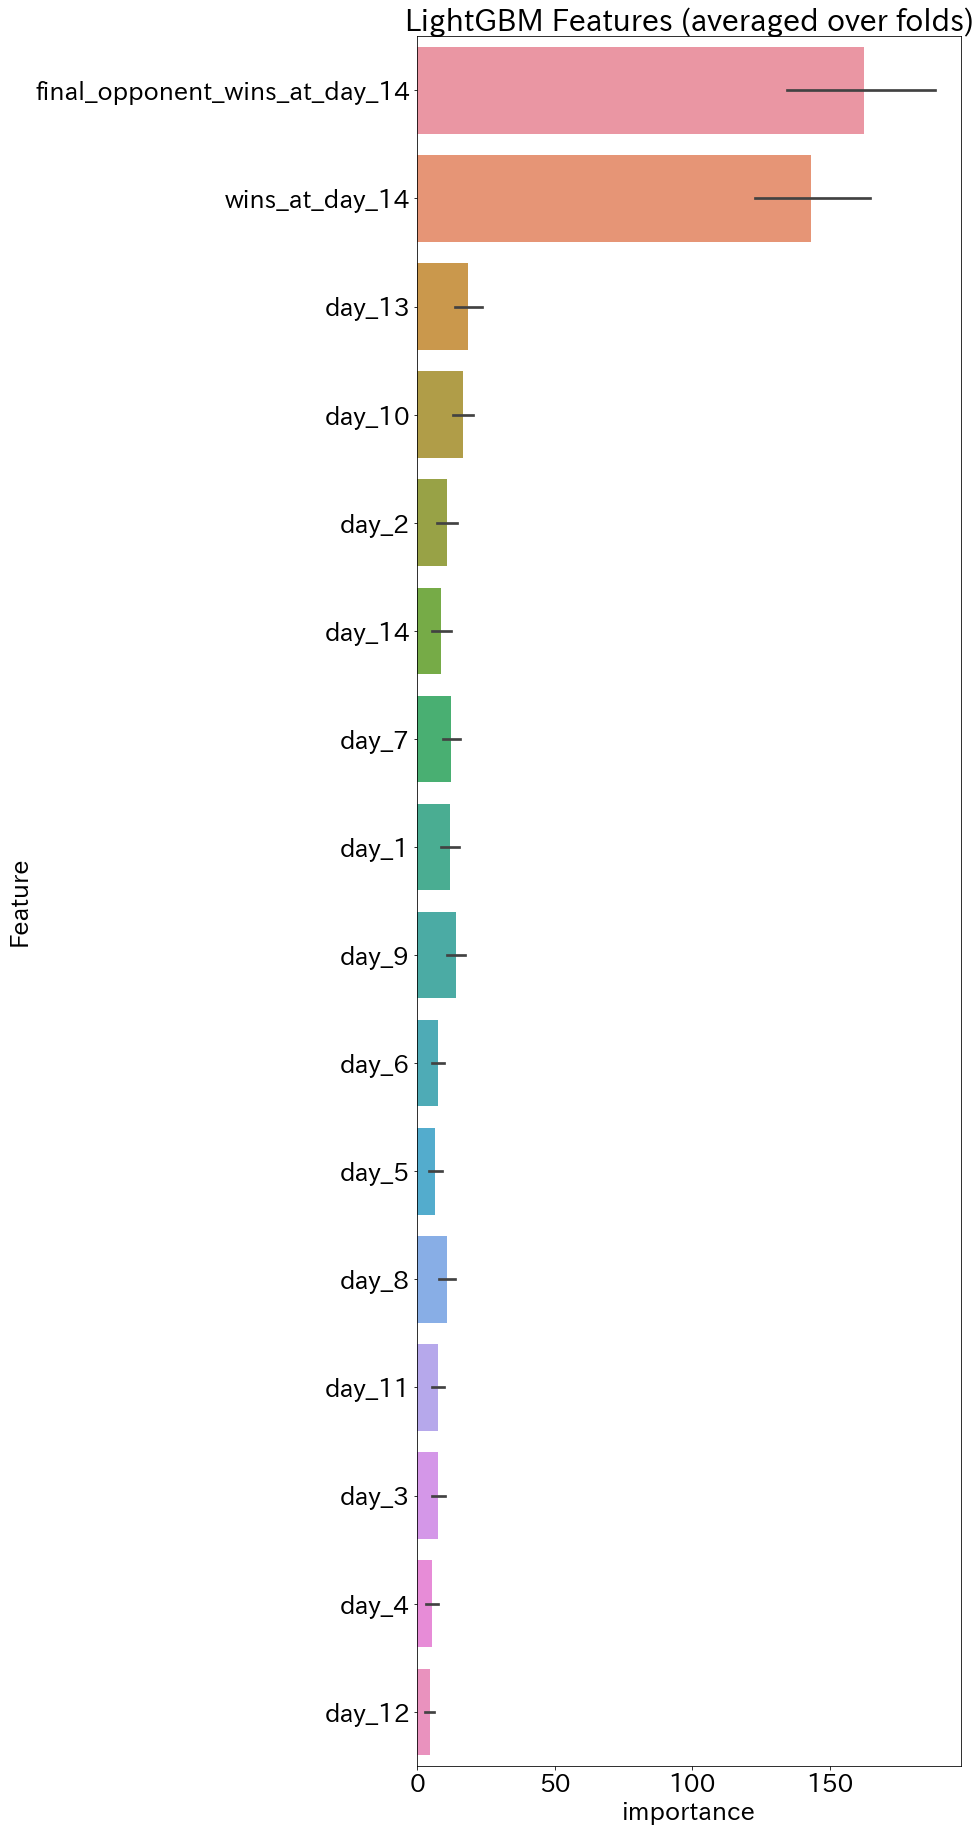

In [30]:
cols = feature_importances.groupby('Feature').mean().sort_values(by="importance", ascending=False)[:200].index

best_features = feature_importances.loc[feature_importances.Feature.isin(cols)]
plt.figure(figsize=(14, 26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()

In [31]:
y_sub = sum(y_preds) / len(y_preds)
y_sub[:10]

array([0.50241834, 0.40231586, 0.49162349, 0.42949792, 0.47949475,
       0.41740852, 0.5419171 , 0.49777656, 0.57132501, 0.43767173])

(array([  7.,  37.,  91., 158., 257., 234., 153.,  70.,  31.,  12.]),
 array([0.3357912 , 0.36837883, 0.40096646, 0.43355409, 0.46614172,
        0.49872935, 0.53131698, 0.56390461, 0.59649223, 0.62907986,
        0.66166749]),
 <a list of 10 Patch objects>)

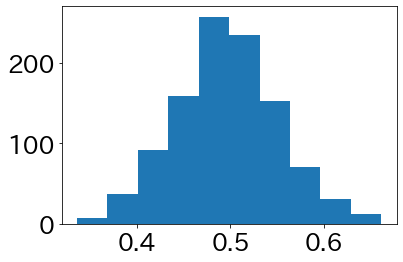

In [32]:
plt.hist(y_sub)

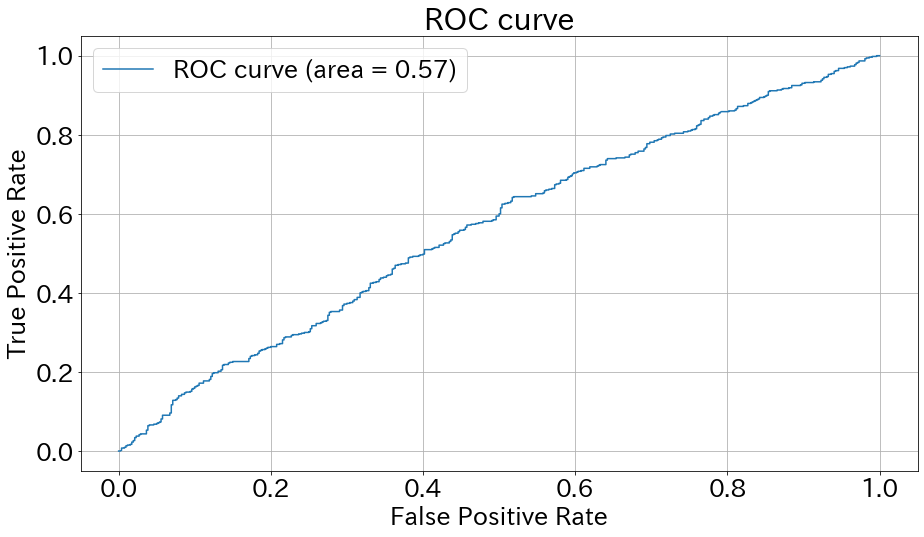

In [33]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_sub)
auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(15, 8))
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [34]:
y_sub = np.where(y_sub > 0.5, 1, 0)
y_sub[:10]

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_sub)

array([[302, 218],
       [257, 273]])

In [36]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_sub)

0.5476190476190477